In [53]:
import open3d as o3d
from sys import argv, exit
import numpy as np
from scipy.spatial.transform import Rotation as R
import copy
import os
import gtsam
from open3d.web_visualizer import draw
import matplotlib.pyplot as plt
np.random.seed(42)

Generating Cube vertices

In [55]:
def getVertices():
    points = [[0, 8, 8], [0, 0, 8], [0, 0, 0], [0, 8, 0], [8, 8, 8], [8, 0, 8], [8, 0, 0], [8, 8, 0]]

    vertices = []

    for ele in points:
        if(ele is not None):
            sphere = o3d.geometry.TriangleMesh.create_sphere(radius=0.2)
            sphere.paint_uniform_color([0.9, 0.2, 0])

            trans = np.identity(4)
            trans[0, 3] = ele[0]
            trans[1, 3] = ele[1]
            trans[2, 3] = ele[2]

            sphere.transform(trans)
            vertices.append(sphere)

    return vertices, points

In [56]:
vertices, points = getVertices()

Generating Robot positions

In [57]:
def getFrames():
    # posei = ( x, y, z, thetaZ(deg) )

    poses = [[-12, 0, 0, 0], [-10, -4, 0, 30], [-8, -8, 0, 60], [-4, -12, 0, 75], [0, -16, 0, 80]]

    frames = []

    for pose in poses:
        T = np.identity(4)
        T[0, 3], T[1, 3], T[2, 3] = pose[0], pose[1], pose[2]
        T[0:3, 0:3] = R.from_euler('z', pose[3], degrees=True).as_matrix()

        frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1.2, origin=[0, 0, 0])
        frame.transform(T)
        frames.append(frame)

    return frames, poses

In [58]:
frames, poses = getFrames()

Visualizing Ground Truth robot positions and cube vertices

In [59]:
def visualizeData(vertices, frames):
    geometries = []
    geometries = geometries + vertices + frames

    o3d.visualization.draw_geometries(geometries)
#     draw(geometries)

In [60]:
visualizeData(vertices, frames)

Generating cube as a local point cloud viewed from five different robot's positions.  
Adding noise in measurement of cube vertices in local frame from robot's five different positions to simulate inaccuracy in depth calculation in real sensors.

In [61]:
def getLocalCubes(points, poses):
    # Returns local point cloud cubes

    points = np.array(points)
    poses = np.array(poses)

    nPoses, nPoints, pointDim = poses.shape[0], points.shape[0], points.shape[1]
    cubes = np.zeros((nPoses, nPoints, pointDim))

    for i, pose in enumerate(poses):
        cube = []

        T = np.identity(4)
        T[0, 3], T[1, 3], T[2, 3] = pose[0], pose[1], pose[2]
        T[0:3, 0:3] = R.from_euler('z', pose[3], degrees=True).as_matrix()

        for pt in np.hstack((points, np.ones((points.shape[0], 1)))):
            ptLocal = np.linalg.inv(T) @ pt.reshape(4, 1)

            cube.append(ptLocal.squeeze(1)[0:3])

        cubes[i] = np.asarray(cube)

    return cubes


def addNoiseCubes(cubes, noise=0):
    noisyCubes = np.zeros(cubes.shape)

    for i in range(cubes.shape[0]):
        noiseMat = np.random.normal(0, noise, cubes[i].size).reshape(cubes[i].shape)
        noisyCubes[i] = cubes[i] + noiseMat

    return noisyCubes

In typical SLAM scenario: Generating two types of noisy pointclouds. Direct measurements of cube vertices would have lower noise while pose estimation using ICP would be having more noise.  
This can also be considered as robot equipped with wheel odometry and lidar (or depth sensors). Wheel odometry would be having higer noise compared to direct landmark measurements.

After going through the next 3-4 cells, you may get confused: Here we are just trying to replicate the scenario where direct measurements of landmarks are decently accurate, but relative pose measurements are relatively inaccurate. To replicate this, we are giving `noisyCubesHigh` to `icp` and replicating high noise relative pose measurements. But you will see that we are still using `noisyCubesLow` as our local measurements, to replicate low noise direct measurements of landmark. In a real scenario, if `noisyCubesLow` is available to you, you will obviously give that itself to `icp`. Here we are just replicating  a particular scenario.

In [62]:
gtCubes = getLocalCubes(points, poses)
noisyCubesHigh = addNoiseCubes(gtCubes, noise=2.5)#1.8
noisyCubesLow = addNoiseCubes(gtCubes, noise=0.15)

Applying ICP to calculate the relative transformations between robot poses for odometry constraints in Pose Graph Optimization.  
ICP is initialized using known correspondences, so we would get a close form solution in 1 step.

In [63]:
def icpTransformations(cubes):
    # T1_2 : 2 wrt 1 

    P1 = cubes[0]
    P2 = cubes[1]
    P3 = cubes[2]
    P4 = cubes[3]
    P5 = cubes[4]

    pcd1, pcd2, pcd3, pcd4, pcd5 = (o3d.geometry.PointCloud(), o3d.geometry.PointCloud(), 
    o3d.geometry.PointCloud(), o3d.geometry.PointCloud(), o3d.geometry.PointCloud())

    pcd1.points = o3d.utility.Vector3dVector(P1)
    pcd2.points = o3d.utility.Vector3dVector(P2)
    pcd3.points = o3d.utility.Vector3dVector(P3)
    pcd4.points = o3d.utility.Vector3dVector(P4)
    pcd5.points = o3d.utility.Vector3dVector(P5)

    corr = np.array([(i, i) for i in range(8)]) 

    p2p = o3d.pipelines.registration.TransformationEstimationPointToPoint()

    T1_2 = p2p.compute_transformation(pcd2, pcd1, o3d.utility.Vector2iVector(corr))
    T2_3 = p2p.compute_transformation(pcd3, pcd2, o3d.utility.Vector2iVector(corr))
    T3_4 = p2p.compute_transformation(pcd4, pcd3, o3d.utility.Vector2iVector(corr))
    T4_5 = p2p.compute_transformation(pcd5, pcd4, o3d.utility.Vector2iVector(corr))

    draw_registration_result(pcd2, pcd1, T1_2)

    trans = np.array([T1_2, T2_3, T3_4, T4_5])

    return trans


def draw_registration_result(source, target, transformation):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0.706, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])
    source_temp.transform(transformation)

    vis = o3d.visualization.Visualizer()
    vis.create_window()
    vis.add_geometry(source_temp)
    vis.add_geometry(target_temp)
    vis.get_render_option().point_size = 15
    vis.run()
    vis.destroy_window()

Registering two point clouds using transformation obtained using ICP. 

In [64]:
trans = icpTransformations(noisyCubesHigh)

Visualizing the quality of ICP transformations by projecting all local point clouds to the first robot's frame.

In [65]:
def registerCubes(trans, cubes):
    # Registering noisy cubes in first frame

    cloud1 = getCloud(cubes[0], [0.9, 0.2, 0])
    cloud2 = getCloud(cubes[1], [0, 0.2, 0.9])
    cloud3 = getCloud(cubes[2], [0.2, 0.9, 0])
    cloud4 = getCloud(cubes[3], [0.5, 0, 0.95])
    cloud5 = getCloud(cubes[4], [0.9, 0.45, 0])

    T1_2 = trans[0]
    T2_3 = trans[1]
    T3_4 = trans[2]
    T4_5 = trans[3]

    cloud2 = [ele.transform(T1_2) for ele in cloud2]
    cloud3 = [ele.transform(T1_2 @ T2_3) for ele in cloud3]
    cloud4 = [ele.transform(T1_2 @ T2_3 @ T3_4) for ele in cloud4]
    cloud5 = [ele.transform(T1_2 @ T2_3 @ T3_4 @ T4_5) for ele in cloud5]

    geometries = cloud1 + cloud2 + cloud3 + cloud4 + cloud5

    o3d.visualization.draw_geometries(geometries)


def getCloud(cube, color):
    vertices = []

    for ele in cube:
        sphere = o3d.geometry.TriangleMesh.create_sphere(radius=0.15)
        sphere.paint_uniform_color(color)

        trans = np.identity(4)
        trans[0, 3] = ele[0]
        trans[1, 3] = ele[1]
        trans[2, 3] = ele[2]

        sphere.transform(trans)
        vertices.append(sphere)

    return vertices

Due to noise in the sensor measurements, vertices are not overlapping.

In [66]:
registerCubes(trans, noisyCubesLow)

## Backend Optimisation [G2O and GTSAM]

### G2O

Generating G2O file for pose graph optimization.  
Robot poses are the form of `VERTEX_SE3:QUAT`, because our landmarks are in 3D. Poses are caculated  using ICP.  
`VERTEX_SE3:QUAT i x y z q_x q_y q_z q_w`  
Odometry edges are of the form `EDGE_SE3:QUAT`.  
`EDGE_SE3:QUAT i j x y z q_x q_y q_z q_w info(x, y, z, theta_x, theta_y, theta_z)`  
Cube vertices are of the form of `VERTEX_SE3:QUAT`. Cube vertices are intialized with respect to first frame.  
Landmark edges are of the form of `EDGE_SE3:QUAT`. Each landmark edge connects a robot position with the 8 cube vertices. So, we have `5x8=40` landmark edges.   
Information matrix for odometry edges, $\omega_{odom}$ = `20 0 0 0 0 0 20 0 0 0 0 20 0 0 0 20 0 0 20 0 20`   
Information matrix for landmark to robot edges, $\omega_{landmark}$ = `40 0 0 0 0 0 40 0 0 0 0 40 0 0 0 0.000001 0 0 0.000001 0 0.000001`  

<img src="./results/landmark_edges.png" width="500"/>
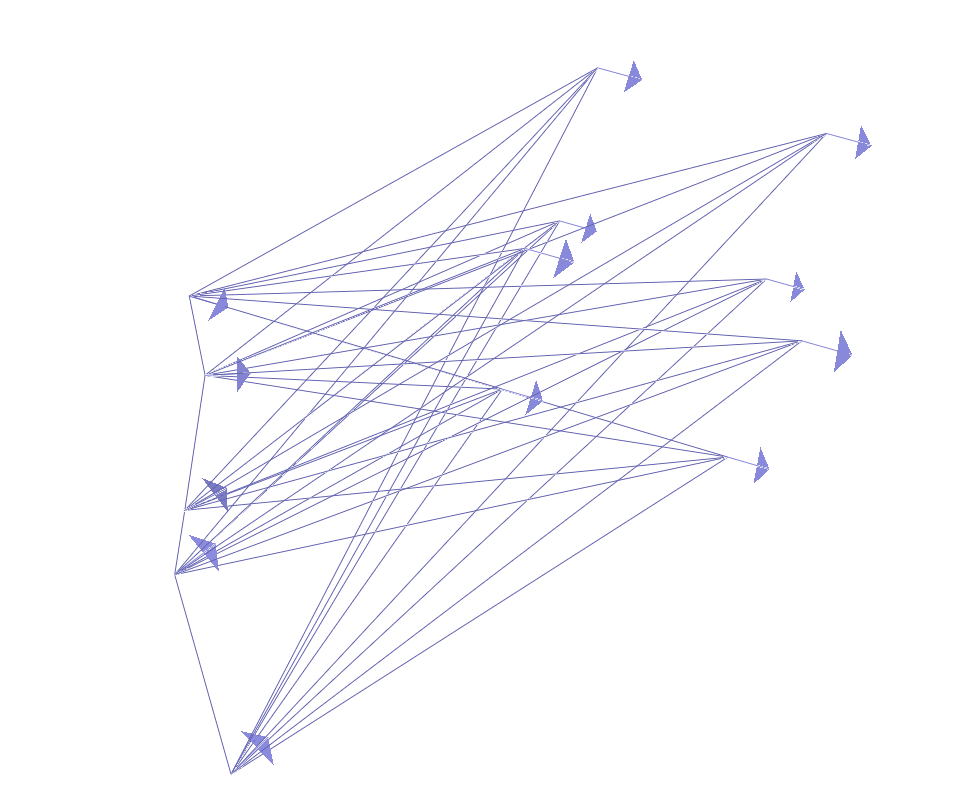

In [67]:
def writeRobotPose(trans, g2o):
    # Tw_1: 1 wrt w

    start = [-12, 0, 0, 0]

    Tw_1 = np.identity(4)
    Tw_1[0, 3], Tw_1[1, 3], Tw_1[2, 3] = start[0], start[1], start[2]
    Tw_1[0:3, 0:3] = R.from_euler('z', start[3], degrees=True).as_matrix()

    T1_2, T2_3, T3_4, T4_5 = trans[0], trans[1], trans[2], trans[3]

    Tw_2 = Tw_1 @ T1_2
    Tw_3 = Tw_2 @ T2_3
    Tw_4 = Tw_3 @ T3_4
    Tw_5 = Tw_4 @ T4_5

    pose1 = [Tw_1[0, 3], Tw_1[1, 3], Tw_1[2, 3]] + list(R.from_matrix(Tw_1[0:3, 0:3]).as_quat())
    pose2 = [Tw_2[0, 3], Tw_2[1, 3], Tw_2[2, 3]] + list(R.from_matrix(Tw_2[0:3, 0:3]).as_quat())
    pose3 = [Tw_3[0, 3], Tw_3[1, 3], Tw_3[2, 3]] + list(R.from_matrix(Tw_3[0:3, 0:3]).as_quat())
    pose4 = [Tw_4[0, 3], Tw_4[1, 3], Tw_4[2, 3]] + list(R.from_matrix(Tw_4[0:3, 0:3]).as_quat())
    pose5 = [Tw_5[0, 3], Tw_5[1, 3], Tw_5[2, 3]] + list(R.from_matrix(Tw_5[0:3, 0:3]).as_quat())

    posesRobot = [pose1, pose2, pose3, pose4, pose5]

    sp = ' '
    g2o.write("PARAMS_SE3OFFSET 0 0 0 0 0 0 0 1\n")
    for i, (x, y, z, qx, qy, qz, qw) in enumerate(posesRobot):
        line = "VERTEX_SE3:QUAT " + str(i) + sp + str(x) + sp + str(y) + sp + str(z) + sp + str(qx) + sp + str(qy) + sp + str(qz) + sp + str(qw) + '\n'
        g2o.write(line)


def writeOdom(trans, g2o):	
    sp = ' '
    info = '20 0 0 0 0 0 20 0 0 0 0 20 0 0 0 20 0 0 20 0 20'

    for i, T in enumerate(trans):
        dx, dy, dz = T[0, 3], T[1, 3], T[2, 3]

        qx, qy, qz, qw = list(R.from_matrix(T[0:3, 0:3]).as_quat())

        line = "EDGE_SE3:QUAT " + str(i) + sp + str(i+1) + sp + str(dx) + sp + str(dy) + sp + str(dz) + sp + str(qx) + sp + str(qy) + sp + str(qz) + sp + str(qw) + sp +  info + '\n'

        g2o.write(line)


def writeCubeVertices(cubes, g2o):
    cube1 = cubes[0]

    start = [-12, 0, 0, 0]

    Tw_1 = np.identity(4)
    Tw_1[0, 3], Tw_1[1, 3], Tw_1[2, 3] = start[0], start[1], start[2]
    Tw_1[0:3, 0:3] = R.from_euler('z', start[3], degrees=True).as_matrix()

    cube = []

    for pt in np.hstack((cube1, np.ones((cube1.shape[0], 1)))):
        ptWorld = Tw_1 @ pt.reshape(4, 1)

        cube.append(ptWorld.squeeze(1)[0:3])


    for i, (x, y, z) in enumerate(cube):
        line = "VERTEX_TRACKXYZ " + str(5+i) + " " + str(x) + " " + str(y) + " " + str(z) + "\n"
        g2o.write(line)


def writeLandmarkEdge(cubes, g2o):
    sp = ' '
    OBSERVATION_INFOR_MAT = "10 0 0 10 0 10"

    for i, cube in enumerate(cubes):
        for j, (x, y, z) in enumerate(cube):
            line  = "EDGE_SE3_TRACKXYZ " + str(i) + sp + str(j+5) + sp + "0" + sp + str(x) + sp + str(y) + sp + str(z) + sp + OBSERVATION_INFOR_MAT + '\n'

            g2o.write(line)


def writeG2o(trans, cubes):
    g2o = open("noise_3d_ldmk.g2o", 'w')

    g2o.write('# Robot poses\n\n')

    writeRobotPose(trans, g2o)

    g2o.write("\n # Cube vertices\n\n")

    writeCubeVertices(cubes, g2o)

    g2o.write('\n# Odometry edges\n\n')

    writeOdom(trans, g2o)

    g2o.write('\n# Landmark edges\n\n')

    writeLandmarkEdge(cubes, g2o)

    g2o.write("\nFIX 0\n")

    g2o.close()

In [68]:
writeG2o(trans, noisyCubesLow)

Optimizing g2o file

In [69]:
def optimize():
    cmd = "g2o -robustKernel Cauchy -robustKernelWidth 1 -o {} -i 50 {} > /dev/null 2>&1".format(
        "opt_3d_ldmk.g2o", "noise_3d_ldmk.g2o")
    os.system(cmd)

In [70]:
optimize()

Reading optimized g2o file. And again registering all local point clouds to the first frame using optimized poses.

In [71]:
def readG2o(fileName):
    f = open(fileName, 'r')
    A = f.readlines()
    f.close()

    poses = []

    for line in A:
        if "VERTEX_SE3:QUAT" in line:
            line = line.strip()
            (ver, ind, x, y, z, qx, qy, qz, qw) = line.split(' ')

            if int(ind) <= 5:
                T = np.identity(4)
                T[0, 3], T[1, 3], T[2, 3] = x, y, z
                T[0:3, 0:3] = R.from_quat([qx, qy, qz, qw]).as_matrix()

                poses.append(T)

    poses = np.asarray(poses)

    return poses


def getRelativeEdge(poses):
    T1_2 = np.linalg.inv(poses[0]) @ poses[1]
    T2_3 = np.linalg.inv(poses[1]) @ poses[2]
    T3_4 = np.linalg.inv(poses[2]) @ poses[3]
    T4_5 = np.linalg.inv(poses[3]) @ poses[4]

    trans = np.array([T1_2, T2_3, T3_4, T4_5])

    return trans

In [72]:
optPoses = readG2o("opt_3d_ldmk.g2o")
optEdges = getRelativeEdge(optPoses)

In [73]:
registerCubes(optEdges, noisyCubesLow)

### GTSAM Optimiser

In [21]:
###############################################################################
## This is not going to work right now GTSAM do not handle EDGE_SE3_TRACKXYZ ##
###############################################################################


# def make_T_from_xyz(xN, yN, zN, QxN, QyN, QzN, QwN):
# 		r = R.from_quat([QxN,QyN, QzN, QwN]).as_matrix()
# 		t = np.array([xN, yN, zN])
# 		T = np.eye(4)
# 		T[:3,:3] = r
# 		T[:3,3] = t
# 		return T
		
# def gtsam_optimisation(save_file, noiselc, x0, y0, t0):
# 	graph, initial = gtsam.readG2o(noiselc, is3D=True)
# 	params = gtsam.LevenbergMarquardtParams()
# 	params.setVerbosity("Termination")  # this will show info about stopping conds
# 	optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial, params)

# 	result = optimizer.optimize()
# 	print("Optimization complete")
# 	print("initial error = ", graph.error(initial))
# 	print("final error = ", graph.error(result))

# 	print("Writing results to file: ", save_file)
# 	graphNoKernel, _ = gtsam.readG2o(noiselc, is3D=False)
# 	gtsam.writeG2o(graphNoKernel, result, save_file)
# 	print("Done!")

# gtsam_optimisation("opt_gtsam_3d_ldmk.g2o", "noise_3d_ldmk.g2o", -12, 0 ,0)
# optPoses_gtsam = readG2o("opt_gtsam_3d_ldmk.g2o")
# optEdges_gtsam = getRelativeEdge(optPoses_gtsam)
# registerCubes(optEdges_gtsam, noisyCubesLow)

In [74]:

def make_T_from_xyz(xN, yN, zN, QxN, QyN, QzN, QwN):
		r = R.from_quat([QxN,QyN, QzN, QwN]).as_matrix()
		t = np.array([xN, yN, zN])
		T = np.eye(4)
		T[:3,:3] = r
		T[:3,3] = t
		return T


def pose_symbol(i):
    	return gtsam.symbol_shorthand.X(i)

def ldmk_symbol(i):
    	return gtsam.symbol_shorthand.L(i)


def get_trans(p1, p2):
    
    R1_w = R.from_quat([p1[3], p1[4], p1[5], p1[6]]).as_matrix()
    R2_w = R.from_quat([p2[3], p2[4], p2[5], p2[6]]).as_matrix()

    T1_w = np.identity(4)
    T2_w = np.identity(4)

    T1_w[0:3, 0:3] = R1_w
    T2_w[0:3, 0:3] = R2_w

    T1_w[0, 3] = p1[0] 
    T1_w[1, 3] = p1[1]
    T1_w[2, 3] = p1[2]

    T2_w[0, 3] = p2[0]
    T2_w[1, 3] = p2[1]
    T2_w[2, 3] = p2[2]  ;\
	T2_1 = np.dot(np.linalg.inv(T1_w), T2_w);\
	return T2_1


def compute_ds(T2_1):
	dx = T2_1[0][3];\
	dy = T2_1[1][3];\
	dz = T2_1[2][3];\
	dqx, dqy, dqz, dqw = list(R.from_matrix(T2_1[:3,:3]).as_quat());\
    return dx, dy, dz, dqx, dqy, dqz, dqw


def get_between_factor(p1, p2):
    T2_1 = get_trans(p1, p2);\
	dx, dy, dz, dqx, dqy, dqz, dqw = compute_ds(T2_1);\
	return gtsam.Pose3(make_T_from_xyz(dx, dy, dz, dqx, dqy, dqz, dqw))



def get_bearing(L, X): 
    T = make_T_from_xyz(*X);\
    b = gtsam.Pose3(T).transformTo(gtsam.Point3(*L));\
	return b #takes point in world coordinates and transforms it to Pose coordinates


def get_range(L, X):  
	return np.sqrt((X[1]-L[1])**2+(X[0]-L[0])**2+(X[2]-L[2])**2)

In [75]:
def robotPose(trans):
    # Tw_1: 1 wrt w

    start = [-12, 0, 0, 0]

    Tw_1 = np.identity(4)
    Tw_1[0, 3], Tw_1[1, 3], Tw_1[2, 3] = start[0], start[1], start[2]
    Tw_1[0:3, 0:3] = R.from_euler('z', start[3], degrees=True).as_matrix()

    T1_2, T2_3, T3_4, T4_5 = trans[0], trans[1], trans[2], trans[3]

    Tw_2 = Tw_1 @ T1_2
    Tw_3 = Tw_2 @ T2_3
    Tw_4 = Tw_3 @ T3_4
    Tw_5 = Tw_4 @ T4_5

    pose1 = [Tw_1[0, 3], Tw_1[1, 3], Tw_1[2, 3]] + list(R.from_matrix(Tw_1[0:3, 0:3]).as_quat())
    pose2 = [Tw_2[0, 3], Tw_2[1, 3], Tw_2[2, 3]] + list(R.from_matrix(Tw_2[0:3, 0:3]).as_quat())
    pose3 = [Tw_3[0, 3], Tw_3[1, 3], Tw_3[2, 3]] + list(R.from_matrix(Tw_3[0:3, 0:3]).as_quat())
    pose4 = [Tw_4[0, 3], Tw_4[1, 3], Tw_4[2, 3]] + list(R.from_matrix(Tw_4[0:3, 0:3]).as_quat())
    pose5 = [Tw_5[0, 3], Tw_5[1, 3], Tw_5[2, 3]] + list(R.from_matrix(Tw_5[0:3, 0:3]).as_quat())

    posesRobot = np.array([pose1, pose2, pose3, pose4, pose5])

    # xN, yN, zN, QxN, QyN, QzN, QwN
    return posesRobot, posesRobot[:,0], posesRobot[:,1], posesRobot[:,2], posesRobot[:,3], posesRobot[:,4], posesRobot[:,5], posesRobot[:,6]


def cubeVertices(cubes):
    cube1 = cubes[0]

    start = [-12, 0, 0, 0]

    Tw_1 = np.identity(4)
    Tw_1[0, 3], Tw_1[1, 3], Tw_1[2, 3] = start[0], start[1], start[2]
    Tw_1[0:3, 0:3] = R.from_euler('z', start[3], degrees=True).as_matrix()

    cube = []

    for pt in np.hstack((cube1, np.ones((cube1.shape[0], 1)))):
        ptWorld = Tw_1 @ pt.reshape(4, 1)

        cube.append(ptWorld.squeeze(1)[0:3])

    return cube # noisy_ldmk


# def landmarkEdge(cubes, posesRobot):
#     range_bearing = []
#     for i, cube in enumerate(cubes):
#         for j, (x, y, z) in enumerate(cube):
#             range = get_range([x,y,z], posesRobot[i])
#             # bearing = get_bearing([x,y,z], posesRobot[i])
#             Mod = np.linalg.norm(np.array([x,y,z]))
#             range_bearing.append([
#                 i,
#                 j,
#                 range,
#                 gtsam.Point3(x/Mod,y/Mod,z/Mod)
#             ])
#     return range_bearing



def landmarkEdge(noisy_ldmk, posesRobot):
    range_bearing = []
    for i,pose in enumerate(posesRobot):
        for j,ldmk in enumerate(noisy_ldmk):
            range_bearing.append([
                i,
                j,
                get_range(ldmk,pose),
                get_bearing(ldmk,pose),
            ])
    return range_bearing

def landmarkEdge_raw():
    global poses, points
    range_bearing = []
    for i,pose in enumerate(poses):
        T = np.identity(4)
        px, py, pz = pose[0], pose[1], pose[2]
        [pqx, pqy, pqz, pqw] = R.from_euler('z', pose[3], degrees=True).as_quat()
        POSE = [px, py, pz, pqx, pqy, pqz, pqw]
        for j,ldmk in enumerate(points):
            range_bearing.append([
                i,
                j,
                get_range(ldmk,POSE),
                get_bearing(ldmk,POSE),
            ])
    return range_bearing

In [76]:


def gtsam_optimisation(xN, yN, zN, QxN, QyN, QzN, QwN, noise_ldmk, range_bearing, pose_sigma, ldmk_sigma, print_log=False):
	graph = gtsam.NonlinearFactorGraph()
	initial = gtsam.Values()
	priorModel = gtsam.noiseModel.Diagonal.Sigmas(pose_sigma)

	if print_log:
		print("Adding poses...")
        
	for idx in range(len(xN)):
		PT = make_T_from_xyz(xN[idx], yN[idx], zN[idx], QxN[idx],QyN[idx], QzN[idx], QwN[idx]);\
        initial.insert(
			pose_symbol(idx), 
			gtsam.Pose3(PT)
		)
		
	PT = make_T_from_xyz(xN[0], yN[0], zN[0], QxN[0],QyN[0], QzN[0], QwN[0])
	graph.add(gtsam.PriorFactorPose3(pose_symbol(0), gtsam.Pose3(PT), priorModel))


	if print_log:
		print("Adding odom edges...")
        

	for idx in range(len(xN)-1):
			graph.add(gtsam.BetweenFactorPose3(
				pose_symbol(idx),
				pose_symbol(idx+1),
				get_between_factor(
                    [xN[idx], yN[idx], zN[idx], QxN[idx], QyN[idx], QzN[idx], QwN[idx]],
                    [xN[idx+1], yN[idx+1], zN[idx+1], QxN[idx+1], QyN[idx+1], QzN[idx+1], QwN[idx+1]]
                ),
				priorModel
			))
    
	if print_log:
		print("Adding ldmk...")

	for idx in range(len(noise_ldmk)):
		initial.insert(
			ldmk_symbol(idx), 
			gtsam.Point3(*noise_ldmk[idx])
		)


	if print_log:
		print("observation edges...")

	for [ps, pt, r, b] in range_bearing:
		range_obs_edge = gtsam.RangeFactor3D(
            pose_symbol(ps),
            ldmk_symbol(pt),
            r,
            gtsam.noiseModel.Diagonal.Sigmas([ldmk_sigma[0]])
        );\
		bearing_obs_edge = gtsam.BearingFactor3D(
            pose_symbol(ps),
            ldmk_symbol(pt),
            gtsam.Unit3(b),
            gtsam.noiseModel.Diagonal.Sigmas([ldmk_sigma[1], ldmk_sigma[2]])
        );\
		graph.add(range_obs_edge)
		graph.add(bearing_obs_edge)
        

	# print("GRAPH START : \n\n", graph)
	
	params = gtsam.LevenbergMarquardtParams()
	if print_log:
		params.setVerbosity("Termination")  # this will show info about stopping conds
	params.setMaxIterations(500)
	optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial, params)

	result = optimizer.optimize()


	print("Writing results to file: ", "opt_gtsam_3d_ldmk.g2o")
	graphNoKernel, _ = gtsam.readG2o("noise_3d_ldmk.g2o", is3D=True)
	gtsam.writeG2o(graphNoKernel, result, "opt_gtsam_3d_ldmk.g2o")
	print("Done!")

	if print_log:
		print("Optimization complete")
		print("initial error = ", graph.error(initial))
		print("final error = ", graph.error(result))
	marginals = gtsam.Marginals(graph, result)


	final_x = []
	final_y = [] 
	final_z = [] 
	final_qx = [] 
	final_qy = [] 
	final_qz = [] 
	final_qw = [] 
	final_ldmk = [] 
	for idx in range(len(xN)):
		T = result.atPose3(pose_symbol(idx)).matrix()
		final_x.append(T[0,3])
		final_y.append(T[1,3])
		final_z.append(T[2,3])
		quat = R.from_matrix(T[:3,:3]).as_quat()
		final_qx.append(quat[0])
		final_qy.append(quat[1])
		final_qz.append(quat[2])
		final_qw.append(quat[3])
		# print("X",idx ," -> ", marginals.marginalCovariance(pose_symbol(idx)))
        
	for idx in range(len(noise_ldmk)):
		final_ldmk.append(result.atPoint3(ldmk_symbol(idx)))
		# print("L",idx ," -> ", marginals.marginalCovariance(ldmk_symbol(idx)))

	return final_x, final_y, final_z, final_qx, final_qy, final_qz, final_qw, final_ldmk


In [77]:
pose_sigma = np.array([0.223607, 0.223607, 0.223607, 0.223607, 0.223607, 0.223607])
ldmk_sigma = np.array([1,1,1])
posesRobot, xN, yN, zN, QxN, QyN, QzN, QwN = robotPose(trans)
noise_ldmk = cubeVertices(noisyCubesLow)
# range_bearing = landmarkEdge(noisyCubesLow, posesRobot)
# range_bearing = landmarkEdge(noise_ldmk, posesRobot)
range_bearing = landmarkEdge_raw()
final_x, final_y, final_z, final_qx, final_qy, final_qz, final_qw, final_ldmk = gtsam_optimisation(xN, yN, zN, QxN, QyN, QzN, QwN, 
                                                                                noise_ldmk, range_bearing, pose_sigma, ldmk_sigma, True)
print(final_x)
optPoses_gtsam = readG2o("opt_gtsam_3d_ldmk.g2o")
optEdges_gtsam = getRelativeEdge(optPoses_gtsam)
registerCubes(optEdges_gtsam, noisyCubesLow)

Adding poses...
Adding odom edges...
Adding ldmk...
observation edges...
Writing results to file:  opt_gtsam_3d_ldmk.g2o
Done!
Optimization complete
initial error =  31.47349229665215
final error =  5.12687115832501
converged
errorThreshold: 5.12687115833 <? 0
absoluteDecrease: 1.40294855688e-05 <? 1e-05
relativeDecrease: 2.73645401738e-06 <? 1e-05
iterations: 5 >? 500
[-12.000000000000158, -10.087737709138866, -7.883524980379216, -8.495620816397333, -5.619049688361009]


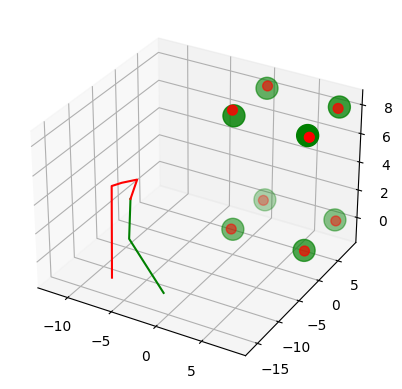

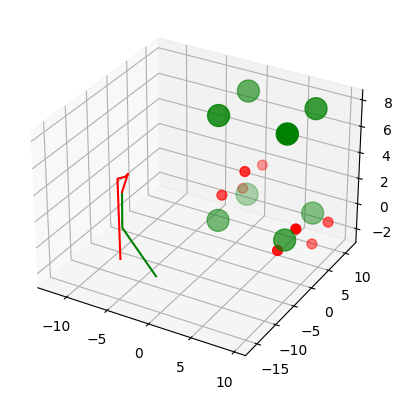

In [52]:

def plot(X,Y, Z, LDMK, xN, yN, zN, noise_ldmk):
    ax = plt.axes(projection='3d')
    ax.plot(X,Y,Z, 'g-')
    ax.plot(xN, yN, zN, 'r-')
    noise_ldmk = np.array(noise_ldmk)
    LDMK = np.array(LDMK)
    ax.scatter3D(LDMK[:,0], LDMK[:,1], LDMK[:,2], s=[250 for _ in range(len(LDMK))], c= 'g')
    ax.scatter3D(noise_ldmk[:,0], noise_ldmk[:,1], noise_ldmk[:,2], s=[50 for _ in range(len(LDMK))], c='r')
    plt.show()

poses = np.array(poses)
plot(poses[:,0], poses[:,1], poses[:,2], points, xN, yN, zN, noise_ldmk)
plot(poses[:,0], poses[:,1], poses[:,2], points, final_x, final_y, final_z, final_ldmk)

In [50]:


def get_between_factor_tmp(p1, p2):
    T2_1 = get_trans(p1, p2);\
	dx, dy, dz, dqx, dqy, dqz, dqw = compute_ds(T2_1)
    print(dx, dy, dz, dqx, dqy, dqz, dqw)

for i in range(len(final_x)-1):
    p1 = [final_x[i], final_y[i], final_z[i], final_qx[i],
            final_qy[i], final_qz[i], final_qw[i]
    ]
    p2 = [final_x[i+1], final_y[i+1], final_z[i+1], final_qx[i+1],
            final_qy[i+1], final_qz[i+1], final_qw[i+1]
    ]
    print(p1)
    print(p2)
    get_between_factor_tmp(p1,p2)

[-11.999512567469516, 0.0010116350456079025, 0.0012323481390622692, -0.00026234549127570163, 3.365495019561625e-05, -0.00015254604875639848, 0.9999999533859442]
[-10.362092005136851, -2.448646287970717, 2.2306887925708665, -0.18070442967121006, 0.06073878886954199, 0.2888506934997364, 0.9382014631669391]
1.6380180108735694 -2.4503277352049317 2.228281189954321 -0.18047727504202557 0.06060386649091373 0.2890036519102024 0.938206807554882
[-10.362092005136851, -2.448646287970717, 2.2306887925708665, -0.18070442967121006, 0.06073878886954199, 0.2888506934997364, 0.9382014631669391]
[-7.70288559870948, -6.750454135092564, 4.490631824605293, -0.37422570723075743, 0.0767142171026384, 0.5146320907869849, 0.7676091844644547]
-0.5347937680484804 -5.489678377856469 0.5115651541456752 -0.22148790128596244 0.04044879514476285 0.2522367179278471 0.9411076679553007
[-7.70288559870948, -6.750454135092564, 4.490631824605293, -0.37422570723075743, 0.0767142171026384, 0.5146320907869849, 0.7676091844644